In [1]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import pyperclip
from tqdm.autonotebook import tqdm
import seaborn as sns
import wandb


/home/sgururaj/miniconda3/envs/amr2/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


In [2]:
pd.options.display.max_rows = 150

In [3]:
api = wandb.Api(timeout=20)

In [4]:
filters = {
    "state": "finished"
}

# from-scratch sweep
sweeps = [
    "40h94d3l", #mscorpus -> risec original
    "lcb73fck", #efgc -> risec original
    "3oh0rbcd", #risec -> mscorpus original
    "eomd5a2e", #risec -> efgc original
    "ao430hya", # mscorpus -> efgc original
    "masb7v5w", # efgc -> mscorpus original
    "v828yikt", # mscorpus -> risec redo
    "x6qwchbj", #mscorpus -> efgc redo
    "sgk8b8c5", #risec -> all redo
    "w4ql7q2s", # efgc -> mscorpus redo
    # "009z7n7n", #mscorpus -> efgc redo
    "15bjmhl0", # efgc -> risec redo
    "vzh30v7p",# efgc -> all 5+20
    "twp4qmrj", #risec -> all 5+20
    "zac74m5c", #mscorpus -> all 5+20
]


runs = []
for sweep_id in sweeps:
    sweep = api.sweep(f"flow-graphs-cmu/narrative-flow-simplified/{sweep_id}")
    runs.extend(sweep.runs)

In [5]:


indomain_sweeps = ["gc51vbsu", "uob7jlo0"]
indomain_runs = []
for sweep_id in indomain_sweeps:
    sweep = api.sweep(f"flow-graphs-cmu/narrative-flow-simplified/{sweep_id}")
    indomain_runs.extend(sweep.runs)

indomain_dfs = []
for run in tqdm(indomain_runs):
    try:
        test_f1  = run.history(keys=["test_f1"], pandas=False)[0]["test_f1"]
        indomain_dfs.append({**run.config, "test_f1": test_f1})
    except:
        continue

indomain_results_df = pd.DataFrame(indomain_dfs)
indomain_results_df.head()
indomain_results_df["src_dataset"] = "zIndomain"
indomain_results_df["tgt_dataset"] = indomain_results_df["dataset"]

  0%|          | 0/162 [00:00<?, ?it/s]

In [6]:
df_dicts = []

for run in tqdm(runs):
    try:
        test_f1  = run.history(keys=["test_f1"], pandas=False)[0]["test_f1"]
        df_dicts.append({**run.config, "test_f1": test_f1})
    except:
        continue

results_df = pd.DataFrame(df_dicts)

  0%|          | 0/540 [00:00<?, ?it/s]

In [7]:
results_df.head()

,lr,gnn,case,seed,epochs,fewshot,patience,base_path,gnn_depth,batch_size,...,use_graph_data,checkpoint_folder,experiment_config,graph_data_source,graph_connection_type,grad_accumulation_steps,train_dataset_instances,train_dataset_instance_hash,test_f1,src_seed
0,0.00002,rgcn,dep_residual,2,30,100,5,/home/sgururaj/src/flow_graphs/,4,4,...,True,/home/sgururaj/src/flow_graphs/checkpoints,dep_residual,dep,residual,1,"[3619, 1152, 2713, 516, 2681, 1125, 2090, 2865...",-7181305545752703268,0.723839,NaN
1,0.00002,rgcn,dep_residual,1,30,100,5,/home/sgururaj/src/flow_graphs/,4,4,...,True,/home/sgururaj/src/flow_graphs/checkpoints,dep_residual,dep,residual,1,"[2573, 1931, 1063, 837, 515, 1178, 1073, 661, ...",-6184697335117306283,0.812458,NaN
2,0.00002,rgcn,dep_residual,0,30,100,5,/home/sgururaj/src/flow_graphs/,4,4,...,True,/home/sgururaj/src/flow_graphs/checkpoints,dep_residual,dep,residual,1,"[2747, 236, 10, 2544, 1337, 3026, 3329, 2949, ...",8172644407290843094,0.773820,NaN
3,0.00002,rgcn,dep_residual,2,30,50,5,/home/sgururaj/src/flow_graphs/,4,4,...,True,/home/sgururaj/src/flow_graphs/checkpoints,dep_residual,dep,residual,1,"[2188, 448, 2658, 1523, 2061, 1076, 2212, 2997...",1680451459040988611,0.681381,NaN
4,0.00002,rgcn,dep_residual,1,30,50,5,/home/sgururaj/src/flow_graphs/,4,4,...,True,/home/sgururaj/src/flow_graphs/checkpoints,dep_residual,dep,residual,1,"[3047, 94, 2349, 2623, 3262, 2170, 3318, 1716,...",6802301093093120722,0.708575,NaN


In [8]:
results_df.to_csv("results/aggregated_results.csv")

In [9]:
dataset_name_mapping = {
    "risec": "RISeC",
    "japflow": "English Flow Graphs",
    "chemu": "Chemical Patents",
    "mscorpus": "Materials Science",
}

In [10]:
results_df.shape

(519, 28)

In [11]:
all_results_df = pd.concat([results_df, indomain_results_df])
all_results_df.shape

(681, 29)

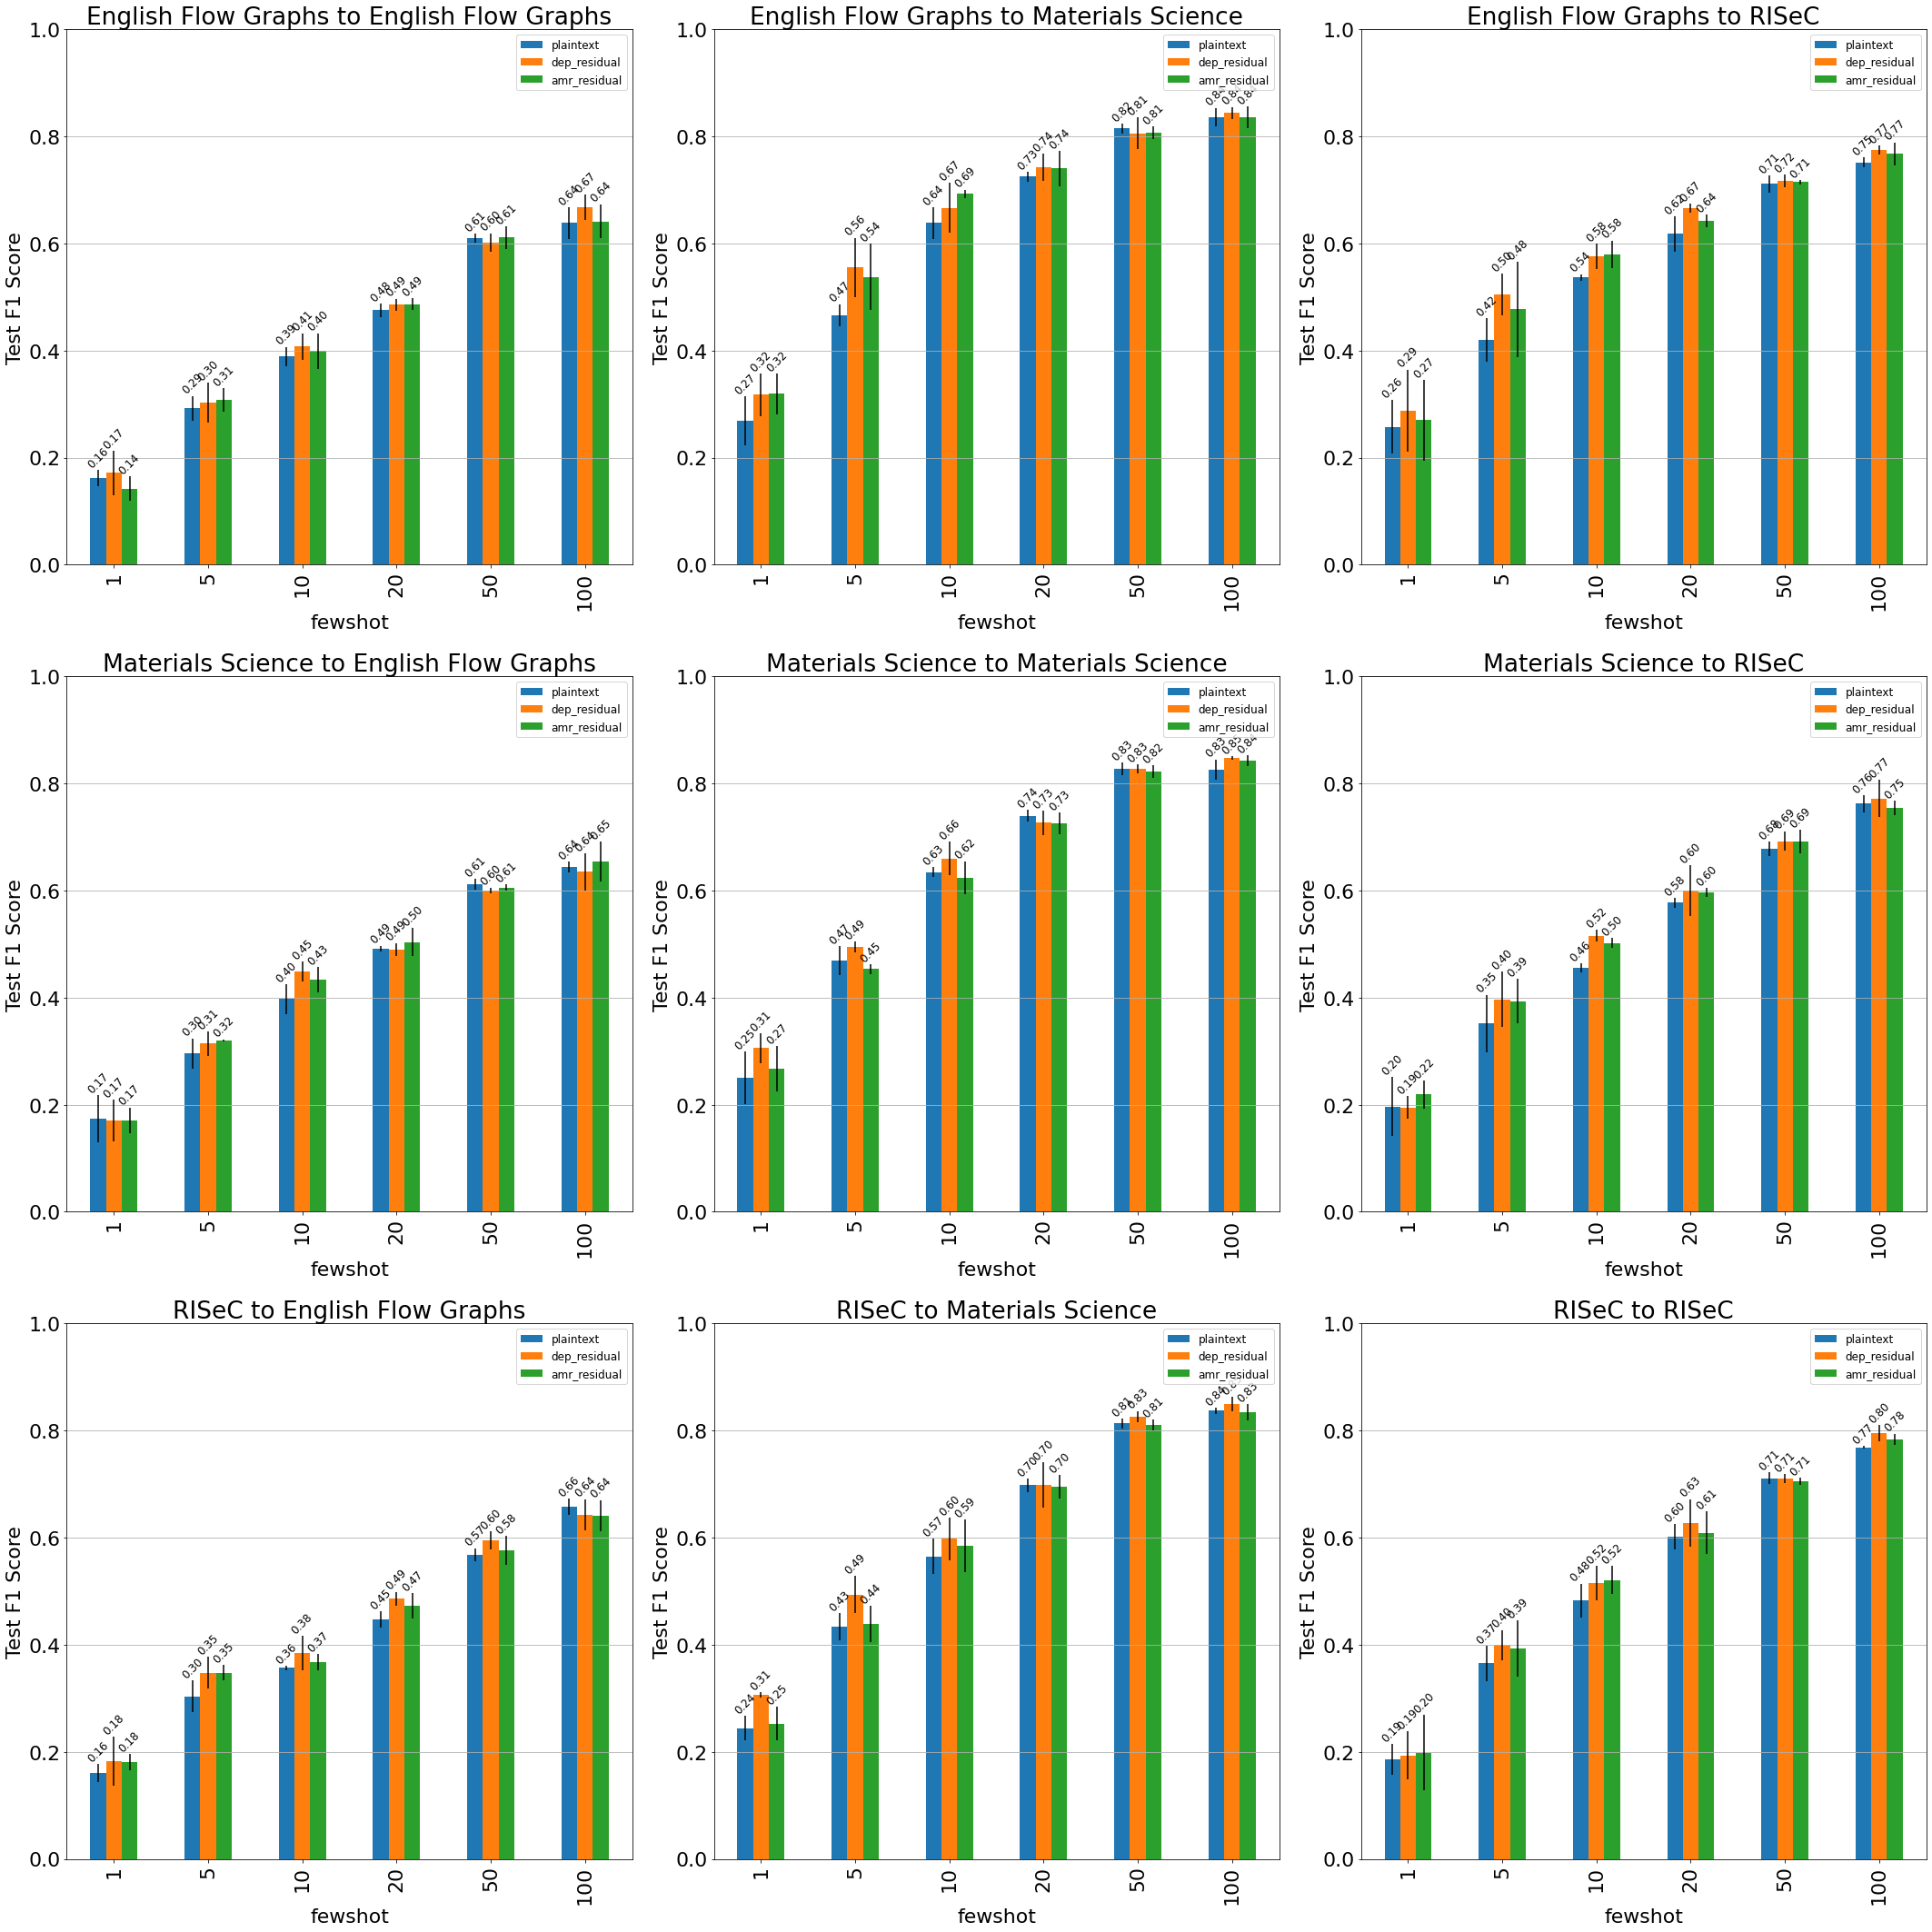

In [17]:
indomain_results_plot_df = indomain_results_df.copy()
indomain_results_plot_df["src_dataset"] = indomain_results_plot_df["tgt_dataset"]
all_results_plot_df = pd.concat([results_df, indomain_results_plot_df])


matplotlib.rcParams.update({'font.size': 22})

src_datasets = set(all_results_plot_df["src_dataset"])
tgt_datasets = set(all_results_plot_df["tgt_dataset"])

fig, axes = plt.subplots(len(tgt_datasets),len(src_datasets), figsize=(len(src_datasets) * 10, len(tgt_datasets) * 10), tight_layout=True)
ax_iter = iter(axes.reshape([-1]))

for src_dataset in sorted(src_datasets):
    for i, tgt_dataset in enumerate(sorted(tgt_datasets)):
        ax = next(ax_iter)

        ax.set_title(f"{dataset_name_mapping[src_dataset]} to {dataset_name_mapping[tgt_dataset]}")
        ax.set_ylim(0, 1)
        ax.set_xlabel("Fewshot Setting")
        ax.set_ylabel("Test F1 Score")
        # if src_dataset == tgt_dataset:
        #     continue
        results_viz = all_results_plot_df[(all_results_plot_df["src_dataset"] == src_dataset) & (all_results_plot_df["tgt_dataset"] == tgt_dataset)].groupby(["fewshot", "case"])["test_f1"].aggregate(["mean", "std"]).unstack(1)
        if len(results_viz) == 0:
            continue
        graph = results_viz["mean"][["plaintext", "dep_residual", "amr_residual"]].plot.bar(ax=ax, yerr=results_viz["std"])
        graph.grid(axis="y", which="both")

        ax.legend(fontsize=12)


        for bars in ax.containers:
            try:
                ax.bar_label(bars, fmt="%2.2f", rotation=45, fontsize=12)
            except:
                pass


In [18]:
case_rename = {
    "amr_residual": "+AMR",
    "dep_residual": "+Dep",
    "plaintext": "Baseline"
}

dataset_rename = {
    "japflow": "EFGC",
    "risec": "RISeC",
    "mscorpus": "MSCorpus",
}

column_rename = {
    "src_dataset": "Source",
    "tgt_dataset": "Target", 
    "case": "Case"
}

In [66]:
unstacked = all_results_df.groupby(["tgt_dataset", "src_dataset", "fewshot", "case"])["test_f1"].aggregate(["mean", "std"]).unstack(2).rename(index={**case_rename, **dataset_rename}).sort_index(axis=0, ascending=False) * 100
unstacked.index = unstacked.index.rename(column_rename)
unstacked

mean                                   \
fewshot                            1          5          10         20    
Target   Source    Case                                                   
RISeC    zIndomain Baseline  18.557663  36.514260  48.266764  60.215457   
                   +Dep      19.313061  39.950417  51.537326  62.740621   
                   +AMR      19.843084  39.274232  52.116609  60.918386   
         MSCorpus  Baseline  19.657933  35.147364  45.607011  57.737701   
                   +Dep      19.440675  39.657239  51.575740  59.996000   
                   +AMR      21.926225  39.378480  50.193879  59.643019   
         EFGC      Baseline  25.753437  42.014459  53.689649  61.781548   
                   +Dep      28.779378  50.483657  57.631419  66.574355   
                   +AMR      27.014104  47.714268  57.987645  64.280306   
MSCorpus zIndomain Baseline  25.024090  46.925136  63.430893  73.981415   
                   +Dep      30.575918  49.461596  66.019630  72.695518   
                   +AMR      26.736546  45.329501  62.441775  72.550474   
         RISeC     Baseline  24.438216  43.377225  56.515076  69.797302   
                   +Dep      30.609621  49.361251  59.779874  69.855748   
                   +AMR      25.271135  43.925612  58.536265  69.522665   
         EFGC      Baseline  26.870130  46.592662  63.842865  72.515964   
                   +Dep      31.731730  55.524119  66.647954  74.223618   
                   +AMR      31.925067  53.781886  69.261229  74.020869   
EFGC     zIndomain Baseline  16.213303  29.255859  38.894991  47.555652   
                   +Dep      17.161929  30.270377  40.731748  48.601082   
                   +AMR      14.206109  30.759153  39.923174  48.690249   
         RISeC     Baseline  16.040974  30.380693  35.662115  44.727589   
                   +Dep      18.238830  34.782704  38.393939  48.577277   
                   +AMR      18.081799  34.779195  36.691555  47.280572   
         MSCorpus  Baseline  17.351801  29.541009  39.746563  49.175934   
                   +Dep      17.049660  31.408071  44.910412  48.977222   
                   +AMR      17.079075  32.047671  43.385952  50.389414   

                                                        std            \
fewshot                            50         100       1         5     
Target   Source    Case                                                 
RISeC    zIndomain Baseline  71.103743  76.907379  2.929147  3.242257   
                   +Dep      71.064428  79.518485  4.462152  2.806032   
                   +AMR      70.594111  78.397933  7.071529  5.222747   
         MSCorpus  Baseline  67.836793  76.243602  5.525374  5.393950   
                   +Dep      69.243134  77.193684  2.117330  5.158593   
                   +AMR      69.193393  75.401217  2.588968  4.172275   
         EFGC      Baseline  71.119582  75.166002  5.029305  4.032051   
                   +Dep      71.698392  77.461577  7.692474  3.907617   
                   +AMR      71.458516  76.759968  7.555507  8.893642   
MSCorpus zIndomain Baseline  82.712833  82.590336  4.896486  2.731417   
                   +Dep      82.747523  84.780156  2.819956  0.990126   
                   +AMR      82.241841  84.269540  4.260760  0.935773   
         RISeC     Baseline  81.374733  83.700916  2.238960  2.478721   
                   +Dep      82.645128  84.978475  0.523471  3.516917   
                   +AMR      81.032254  83.495596  3.108912  3.390701   
         EFGC      Baseline  81.503530  83.607773  4.623619  2.084716   
                   +Dep      80.544279  84.389986  3.988814  5.558096   
                   +AMR      80.666806  83.589497  3.788544  6.146421   
EFGC     zIndomain Baseline  61.011678  63.819234  1.510024  2.290348   
                   +Dep      60.155674  66.743952  4.131180  3.771901   
                   +AMR      61.111389  64.143319  2.267441  2.248768   
         RISeC     Baseline  56

In [67]:
unstacked["mean"]

fewshot                            1          5          10         20   \
Target   Source    Case                                                   
RISeC    zIndomain Baseline  18.557663  36.514260  48.266764  60.215457   
                   +Dep      19.313061  39.950417  51.537326  62.740621   
                   +AMR      19.843084  39.274232  52.116609  60.918386   
         MSCorpus  Baseline  19.657933  35.147364  45.607011  57.737701   
                   +Dep      19.440675  39.657239  51.575740  59.996000   
                   +AMR      21.926225  39.378480  50.193879  59.643019   
         EFGC      Baseline  25.753437  42.014459  53.689649  61.781548   
                   +Dep      28.779378  50.483657  57.631419  66.574355   
                   +AMR      27.014104  47.714268  57.987645  64.280306   
MSCorpus zIndomain Baseline  25.024090  46.925136  63.430893  73.981415   
                   +Dep      30.575918  49.461596  66.019630  72.695518   
                   +AMR      26.736546  45.329501  62.441775  72.550474   
         RISeC     Baseline  24.438216  43.377225  56.515076  69.797302   
                   +Dep      30.609621  49.361251  59.779874  69.855748   
                   +AMR      25.271135  43.925612  58.536265  69.522665   
         EFGC      Baseline  26.870130  46.592662  63.842865  72.515964   
                   +Dep      31.731730  55.524119  66.647954  74.223618   
                   +AMR      31.925067  53.781886  69.261229  74.020869   
EFGC     zIndomain Baseline  16.213303  29.255859  38.894991  47.555652   
                   +Dep      17.161929  30.270377  40.731748  48.601082   
                   +AMR      14.206109  30.759153  39.923174  48.690249   
         RISeC     Baseline  16.040974  30.380693  35.662115  44.727589   
                   +Dep      18.238830  34.782704  38.393939  48.577277   
                   +AMR      18.081799  34.779195  36.691555  47.280572   
         MSCorpus  Baseline  17.351801  29.541009  39.746563  49.175934   
                   +Dep      17.049660  31.408071  44.910412  48.977222   
                   +AMR      17.079075  32.047671  43.385952  50.389414   

fewshot                            50         100  
Target   Source    Case                            
RISeC    zIndomain Baseline  71.103743  76.907379  
                   +Dep      71.064428  79.518485  
                   +AMR      70.594111  78.397933  
         MSCorpus  Baseline  67.836793  76.243602  
                   +Dep      69.243134  77.193684  
                   +AMR      69.193393  75.401217  
         EFGC      Baseline  71.119582  75.166002  
                   +Dep      71.698392  77.461577  
                   +AMR      71.458516  76.759968  
MSCorpus zIndomain Baseline  82.712833  82.590336  
                   +Dep      82.747523  84.780156  
                   +AMR      82.241841  84.269540  
         RISeC     Baseline  81.374733  83.700916  
                   +Dep      82.645128  84.978475  
                   +AMR      81.032254  83.495596  
         EFGC      Baseline  81.503530  83.607773  
                   +Dep      80.544279  84.389986  
                   +AMR      80.666806  83.589497  
EFGC     zIndomain Baseline  61.011678  63.819234  
                   +Dep      60.155674  66.743952  
                   +AMR      61.111389  64.143319  
         RISeC     Baseline  56.850973  65.791878  
                   +Dep      59.522805  64.297667  
                   +AMR      57.653516  64.120789  
         MSCorpus  Baseline  61.193961  64.438725  
                   +Dep      60.014800  63.508182  
                   +AMR      60.582206  65.394217

In [68]:
max_per_pair = unstacked["mean"].max(level=[0,1])
max_per_pair

dfs = []
for case in case_rename.values():
    df = max_per_pair.copy()
    df["case"] = case
    dfs.append(df)


best_per_case = pd.concat(dfs).set_index("case", append=True).sort_index(ascending=False) == unstacked["mean"]
best_per_case

/home/sgururaj/miniconda3/envs/amr2/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  """Entry point for launching an IPython kernel.


fewshot                          1      5     10     20     50    100
Target   Source    case                                              
RISeC    zIndomain Baseline  False  False  False  False   True  False
                   +Dep      False   True  False   True  False   True
                   +AMR       True  False   True  False  False  False
         MSCorpus  Baseline  False  False  False  False  False  False
                   +Dep      False   True   True   True   True   True
                   +AMR       True  False  False  False  False  False
         EFGC      Baseline  False  False  False  False  False  False
                   +Dep       True   True  False   True   True   True
                   +AMR      False  False   True  False  False  False
MSCorpus zIndomain Baseline  False  False  False   True  False  False
                   +Dep       True   True   True  False   True   True
                   +AMR      False  False  False  False  False  False
         RISeC     Baseline  False  False  False  False  False  False
                   +Dep       True   True   True   True   True   True
                   +AMR      False  False  False  False  False  False
         EFGC      Baseline  False  False  False  False   True  False
                   +Dep      False   True  False   True  False   True
                   +AMR       True  False   True  False  False  False
EFGC     zIndomain Baseline  False  False  False  False  False  False
                   +Dep       True  False   True  False  False   True
                   +AMR      False   True  False   True   True  False
         RISeC     Baseline  False  False  False  False  False   True
                   +Dep       True   True   True   True   True  False
                   +AMR      False  False  False  False  False  False
         MSCorpus  Baseline   True  False  False  False   True  False
                   +Dep      False  False   True  False  False  False
                   +AMR      False   True  False   True  False   True

In [69]:
new_df = pd.DataFrame()
bold_df = pd.DataFrame()

for column in unstacked["mean"].columns:
    
    new_df[column] = unstacked["mean"][column].apply("{:.1f}".format, axis=0).str.cat(unstacked["std"][column].apply(" \small{{ \color{{gray}} ({:.1f})}}".format))
    bold_df[column] = unstacked["mean"][column].apply("\\textbf{{{:.1f}".format, axis=0).str.cat(unstacked["std"][column].apply(" \small{{ \color{{gray}} ({:.1f})}}}}".format))

new_df[best_per_case] = bold_df[best_per_case]

new_df

1    \
Target   Source    Case                                                  
RISeC    zIndomain Baseline           18.6 \small{ \color{gray} (2.9)}   
                   +Dep               19.3 \small{ \color{gray} (4.5)}   
                   +AMR      \textbf{19.8 \small{ \color{gray} (7.1)}}   
         MSCorpus  Baseline           19.7 \small{ \color{gray} (5.5)}   
                   +Dep               19.4 \small{ \color{gray} (2.1)}   
                   +AMR      \textbf{21.9 \small{ \color{gray} (2.6)}}   
         EFGC      Baseline           25.8 \small{ \color{gray} (5.0)}   
                   +Dep      \textbf{28.8 \small{ \color{gray} (7.7)}}   
                   +AMR               27.0 \small{ \color{gray} (7.6)}   
MSCorpus zIndomain Baseline           25.0 \small{ \color{gray} (4.9)}   
                   +Dep      \textbf{30.6 \small{ \color{gray} (2.8)}}   
                   +AMR               26.7 \small{ \color{gray} (4.3)}   
         RISeC     Baseline           24.4 \small{ \color{gray} (2.2)}   
                   +Dep      \textbf{30.6 \small{ \color{gray} (0.5)}}   
                   +AMR               25.3 \small{ \color{gray} (3.1)}   
         EFGC      Baseline           26.9 \small{ \color{gray} (4.6)}   
                   +Dep               31.7 \small{ \color{gray} (4.0)}   
                   +AMR      \textbf{31.9 \small{ \color{gray} (3.8)}}   
EFGC     zIndomain Baseline           16.2 \small{ \color{gray} (1.5)}   
                   +Dep      \textbf{17.2 \small{ \color{gray} (4.1)}}   
                   +AMR               14.2 \small{ \color{gray} (2.3)}   
         RISeC     Baseline           16.0 \small{ \color{gray} (1.7)}   
                   +Dep      \textbf{18.2 \small{ \color{gray} (4.5)}}   
                   +AMR               18.1 \small{ \color{gray} (1.5)}   
         MSCorpus  Baseline  \textbf{17.4 \small{ \color{gray} (4.4)}}   
                   +Dep               17.0 \small{ \color{gray} (3.8)}   
                   +AMR               17.1 \small{ \color{gray} (2.4)}   

                                                                   5    \
Target   Source    Case                                                  
RISeC    zIndomain Baseline           36.5 \small{ \color{gray} (3.2)}   
                   +Dep      \textbf{40.0 \small{ \color{gray} (2.8)}}   
                   +AMR               39.3 \small{ \color{gray} (5.2)}   
         MSCorpus  Baseline           35.1 \small{ \color{gray} (5.4)}   
                   +Dep      \textbf{39.7 \small{ \color{gray} (5.2)}}   
                   +AMR               39.4 \small{ \color{gray} (4.2)}   
         EFGC      Baseline           42.0 \small{ \color{gray} (4.0)}   
                   +Dep      \textbf{50.5 \small{ \color{gray} (3.9)}}   
                   +AMR               47.7 \small{ \color{gray} (8.9)}   
MSCorpus zIndomain Baseline           46.9 \small{ \color{gray} (2.7)}   
                   +Dep      \textbf{49.5 \small{ \color{gray} (1.0)}}   
                   +AMR               45.3 \small{ \color{gray} (0.9)}   
         RISeC     Baseline           43.4 \small{ \color{gray} (2.5)}   
                   +Dep      \textbf{49.4 \small{ \color{gray} (3.5)}}   
                   +AMR               43.9 \small{ \color{gray} (3.4)}   
         EFGC      Baseline           46.6 \small{ \color{gray} (2.1)}   
                   +Dep      \textbf{55.5 \small{ \color{gray} (5.6)}}   
                   +AMR               53.8 \small{ \color{gray} (6.1)}   
EFGC     zIndomain Baseline           29.3 \small{ \color{gray} (2.3)}   
                   +Dep               30.3 \small{ \color{gray} (3.8)}   
                   +AMR      \textbf{30.8 \small{ \color{gray} (2.2)}}   
         RISeC     Baseline           30.4 \small{ \color{gray} (3.0)}   
                   +Dep      \textbf{34.8 \small{ \color{gray} (3.0)}}   
                   +AMR               34.8 \small{ \color{gray} (1.4)}

In [70]:
print(new_df.to_latex(column_format="l" * 9, escape=False).replace("zIndomain", "Indomain") + "\n" * 50)

\begin{tabular}{lllllllll}
\toprule
     &          &      &                                        1   &                                        5   &                                        10  &                                        20  &                                        50  &                                        100 \\
Target & Source & Case &                                            &                                            &                                            &                                            &                                            &                                            \\
\midrule
RISeC & Indomain & Baseline &           18.6 \small{ \color{gray} (2.9)} &           36.5 \small{ \color{gray} (3.2)} &           48.3 \small{ \color{gray} (3.1)} &           60.2 \small{ \color{gray} (2.3)} &  \textbf{71.1 \small{ \color{gray} (1.1)}} &           76.9 \small{ \color{gray} (0.2)} \\
     &          & +Dep &           19.3 \small{ \color{gray} (

In [24]:
unstacked = indomain_results_df.groupby(["tgt_dataset", "src_dataset", "fewshot", "case"])["test_f1"].aggregate(["mean", "std"]).unstack(2).rename(index={**case_rename, **dataset_rename}).sort_index(axis=0, ascending=False) * 100
unstacked.index = unstacked.index.rename(column_rename)

max_per_pair = unstacked["mean"].max(level=[0,1])
max_per_pair

dfs = []
for case in case_rename.values():
    df = max_per_pair.copy()
    df["case"] = case
    dfs.append(df)
best_per_case = pd.concat(dfs).set_index("case", append=True).sort_index(ascending=False) == unstacked["mean"]

new_df = pd.DataFrame()
bold_df = pd.DataFrame()

for column in unstacked["mean"].columns:
    
    new_df[column] = unstacked["mean"][column].apply("{:.1f}".format, axis=0).str.cat(unstacked["std"][column].apply(" \small{{ \color{{gray}} ({:.1f})}}".format))
    bold_df[column] = unstacked["mean"][column].apply("\\textbf{{{:.1f}".format, axis=0).str.cat(unstacked["std"][column].apply(" \small{{ \color{{gray}} ({:.1f})}}}}".format))

new_df[best_per_case] = bold_df[best_per_case]
print(new_df.to_latex(column_format="l" * 9, escape=False).replace("zIndomain", "Indomain"))

\begin{tabular}{lllllllll}
\toprule
     &           &      &                                        1   &                                        5   &                                        10  &                                        20  &                                        50  &                                        100 \\
Target & Source & Case &                                            &                                            &                                            &                                            &                                            &                                            \\
\midrule
RISeC & Indomain & Baseline &           18.6 \small{ \color{gray} (2.9)} &           36.5 \small{ \color{gray} (3.2)} &           48.3 \small{ \color{gray} (3.1)} &           60.2 \small{ \color{gray} (2.3)} &  \textbf{71.1 \small{ \color{gray} (1.1)}} &           76.9 \small{ \color{gray} (0.2)} \\
     &           & +Dep &           19.3 \small{ \color{gray}

/home/sgururaj/miniconda3/envs/amr2/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  after removing the cwd from sys.path.


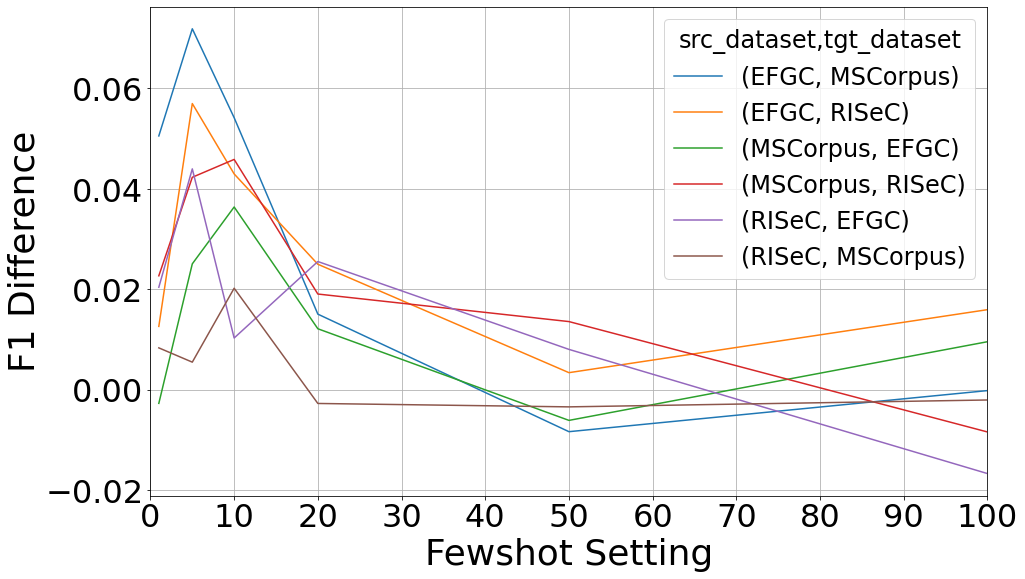

In [76]:
matplotlib.rcParams.update({'font.size': 24})


fig, axes = plt.subplots(figsize=(15,9))

amr_results = results_df[results_df["case"] == "amr_residual"].groupby(["src_dataset", "tgt_dataset", "fewshot"])["test_f1"].mean().rename(index=dataset_rename)
plaintext_results = results_df[results_df["case"] == "plaintext"].groupby(["src_dataset", "tgt_dataset", "fewshot"])["test_f1"].mean().rename(index=dataset_rename)
(amr_results - plaintext_results).unstack().T.plot(ax=axes)

axes.grid()
axes.set_ylabel("F1 Difference", fontsize=36)
axes.set_xlabel("Fewshot Setting", fontsize=36)
axes.set_xticks(range(0,110,10))
axes.set_xlim(0, 100)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# axes.set_title("F1 difference vs fewshot, AMR vs Baseline")
fig.savefig("f1_diff_amr.png", bbox_inches="tight")

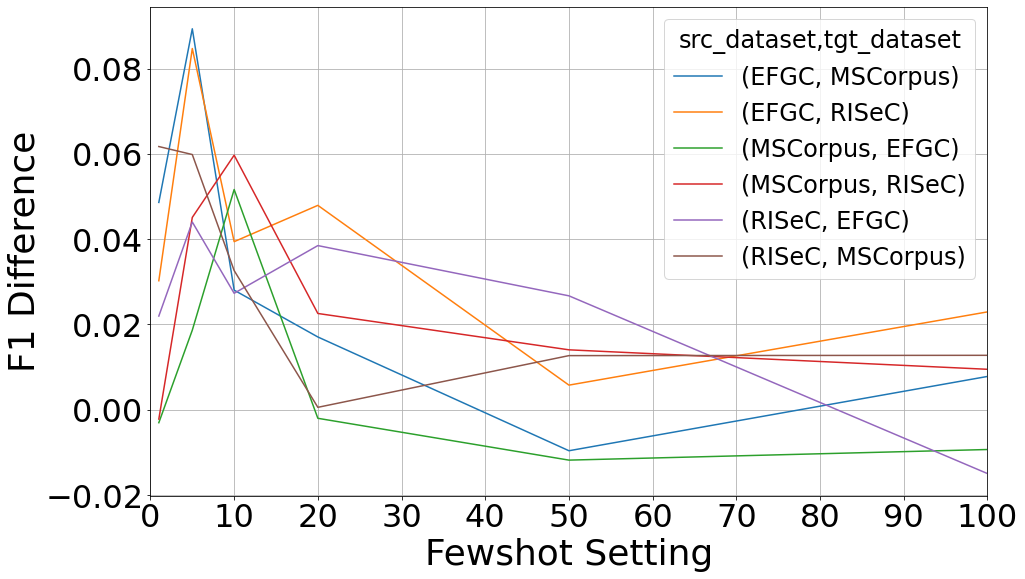

In [75]:
fig, axes = plt.subplots(figsize=(15,9))

dep_results = results_df[results_df["case"] == "dep_residual"].groupby(["src_dataset", "tgt_dataset", "fewshot"])["test_f1"].mean().rename(index=dataset_rename)
plaintext_results = results_df[results_df["case"] == "plaintext"].groupby(["src_dataset", "tgt_dataset", "fewshot"])["test_f1"].mean().rename(index=dataset_rename)
(dep_results - plaintext_results).unstack().T.plot(ax=axes)

axes.grid()
axes.set_ylabel("F1 Difference", fontsize=36)
axes.set_xlabel("Fewshot Setting", fontsize=36)
axes.set_xticks(range(0,110,10))
axes.set_xlim(0, 100)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# axes.set_title("F1 difference vs fewshot, Dependencies vs Baseline")
fig.savefig("f1_diff_dependencies.png", bbox_inches="tight")

In [74]:
unstacked["mean"][5].unstack()["+AMR"].unstack()

Source,EFGC,MSCorpus,RISeC,zIndomain
Target,,,,
EFGC,NaN,32.047671,34.779195,30.759153
MSCorpus,53.781886,NaN,43.925612,45.329501
RISeC,47.714268,39.378480,NaN,39.274232


In [28]:
(unstacked["mean"][5].unstack()["+AMR"].unstack() - unstacked["mean"][5].unstack()["Baseline"].unstack())


Source,zIndomain
Target,
EFGC,1.503294
MSCorpus,-1.595635
RISeC,2.759972


In [29]:
unstacked["mean"][5].unstack()["+Dep"].unstack() - unstacked["mean"][5].unstack()["Baseline"].unstack() 

Source,zIndomain
Target,
EFGC,1.014518
MSCorpus,2.536460
RISeC,3.436157
